# Overview



In [1]:
#Core imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#Stem words 
from nltk.stem.porter import PorterStemmer

#regular expressions 
import re

#most common words
from collections import Counter 


[nltk_data] Downloading package stopwords to /Users/joyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Import data

data = pd.read_csv('Advertisement_Transcripts.csv')

In [3]:
#explore data
data.info()

#5 columns with 1,9935 enties 
#the label column is blank and will be dropped for exploration 
#Key data is the Ad_copy column however the Category will be interesting to explore in relation to bias score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         1935 non-null   object 
 1   Advertiser       1935 non-null   object 
 2   Product_or_spot  1935 non-null   object 
 3   Ad_copy          1935 non-null   object 
 4   label            0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 75.8+ KB


In [4]:
#Checking for blank rows 

# Show blank rows
blank_rows = data[data.isnull().all(axis=1)]
print("Blank rows:\n", blank_rows)

# Drop all blank rows
data.dropna(how='all', inplace=True)

print("Number of rows after removing blank rows:", len(data))


Blank rows:
      Category Advertiser Product_or_spot Ad_copy  label
1935      NaN        NaN             NaN     NaN    NaN
Number of rows after removing blank rows: 1935


In [5]:
# Check for duplicates in the 'Ad_copy' column
duplicate_count = data.duplicated(subset=['Ad_copy']).sum()
print(f"There are {duplicate_count} duplicates in the 'Ad_copy' column.")

# Remove duplicates from the 'Ad_copy' column
data.drop_duplicates(subset=['Ad_copy'], inplace=True)

# Print the updated number of duplicates
updated_duplicate_count = data.duplicated(subset=['Ad_copy']).sum()
print(f"Now there are {updated_duplicate_count} duplicates in the 'Ad_copy' column.")


There are 26 duplicates in the 'Ad_copy' column.
Now there are 0 duplicates in the 'Ad_copy' column.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 1934
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         1909 non-null   object 
 1   Advertiser       1909 non-null   object 
 2   Product_or_spot  1909 non-null   object 
 3   Ad_copy          1909 non-null   object 
 4   label            0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 89.5+ KB


In [7]:
#Explore groups
category_counts = data['Category'].value_counts()

print('Category counts:\n', category_counts)


Category counts:
 Automotive               281
Food & Beverage          242
Home & Personal Care     213
Travel                   191
Advocacy                 153
Financial                141
Beauty                   101
Services                  98
Health Care               75
Media & Entertainment     73
Alcohol & Spirits         64
Restaurants               51
Retail                    47
Insurance                 43
Telecommunications        42
Education                 24
Electronics               16
Technology                13
Sports                    12
Residential               11
Political                  8
Agricultural               5
Appliances                 5
Name: Category, dtype: int64


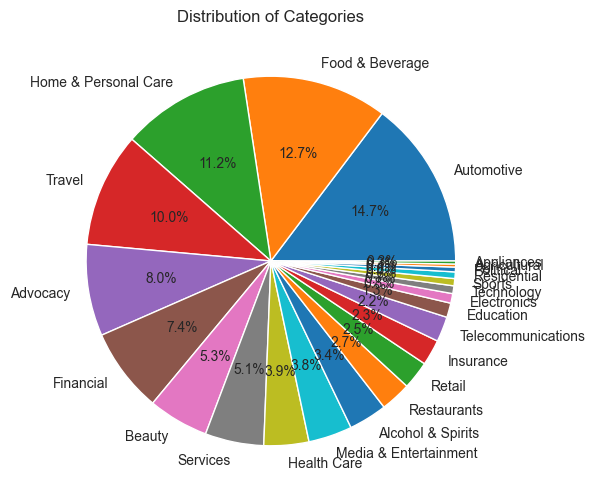

In [8]:
#Visual look at Categories 

sns.set_style('whitegrid')
plt.figure(figsize=(6, 6))
plt.title('Distribution of Categories')
sns.color_palette('pastel')
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.show()

#the smaller percentage not visible 

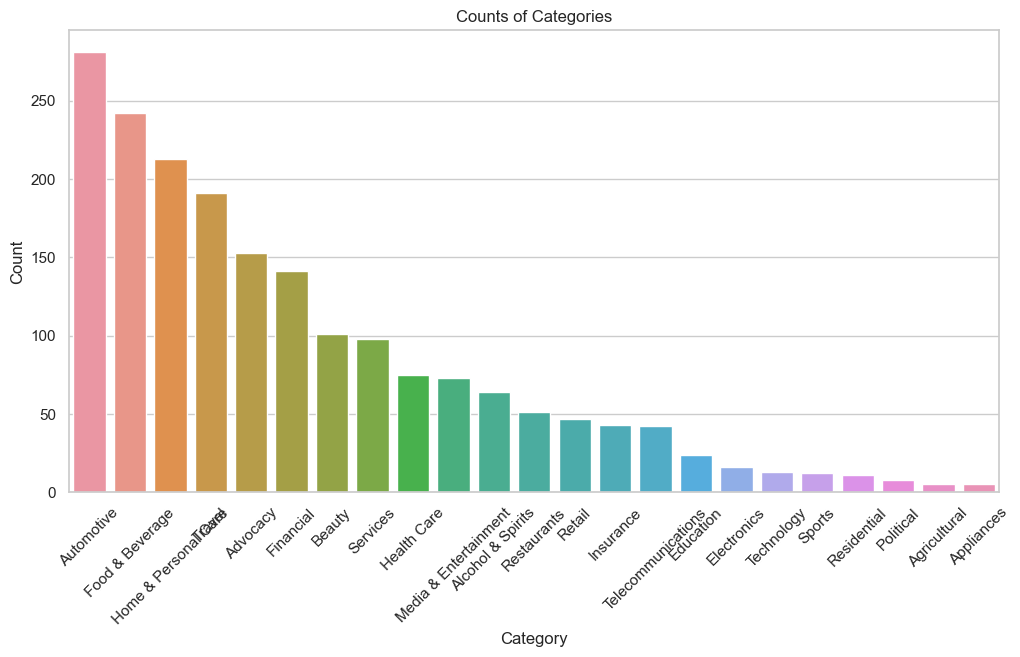

In [9]:
#Display in bar chart 

sns.set(style="whitegrid")

category_counts = data['Category'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)


plt.title("Counts of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)  


plt.show()


Cleaning Data
- Drop columns not needed
- Add new column for clean data
- Remove special charters and number √®
- convert to all lower case 
- Remove quotation marks ""
- Remove number phone numbers and price 7707937550
- remove website 
- Newline \n
- Stop words but keep the genered pronouns
- 
- Tokenize
- Stemming: getting the root form of a word.

In [10]:
#Checking for other options that would need to be removed 

random_sample = data.sample(n=5)[['Ad_copy']]

display(random_sample)


,Ad_copy
1833,Call today for a free Kissimmee St. Cloud visi...
1461,Jobs are leaving the state in record numbers w...
147,Sea otters were once on the brink of extinctio...
764,I wasn't born knowing how to borrow money. I m...
620,Dream Angels. Heavenly. The fragrance collecti...


In [11]:
# Drop unnecessary columns
columns_to_drop = ['label', 'Advertiser', 'Product_or_spot']

for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=column, inplace=True)


data.head(1)

,Category,Ad_copy
0,Advocacy,Women make up seventy percent of the labor for...


In [12]:
#Cleaning and pre-processing data

# Remove gendered pronouns from the stop words set as this is needed for the testing
gendered_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself'}
stop_words = stop_words.difference(gendered_pronouns)



def clean_text(text):
    # Remove special characters, numbers, and quotation marks
    cleaned_text = re.sub(r"[^a-zA-Z'\s]", " ", text)

    # Convert the text to lowercase
    cleaned_text = cleaned_text.lower()

    # Remove phone numbers and prices
    cleaned_text = re.sub(r"\b\d{5,}\b", "", cleaned_text)

    # Remove website URLs
    cleaned_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*'(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", cleaned_text)

    # Replace newline characters with spaces
    cleaned_text = cleaned_text.replace("\n", " ")

    # Remove 's (apostrophe followed by s)
    cleaned_text = re.sub(r"'s", "", cleaned_text)

    # Remove stopwords while keeping gendered pronouns
    words = cleaned_text.split()
    words = [word for word in words if word not in stop_words]
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the cleaning function to the new column
data['clean_copy'] = data['Ad_copy'].apply(clean_text)

In [13]:
# Tokenize https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/

def tokenize_text(text):
    return word_tokenize(text)

# Apply the tokenizing function to the clean_copy column
data['clean_copy'] = data['clean_copy'].apply(tokenize_text)




In [14]:
#Stem words 

stemmer = PorterStemmer()

def stem_words(words):
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

# Apply the stemming function to the clean_copy column
data['clean_copy'] = data['clean_copy'].apply(stem_words)



In [15]:
#Checking data
random_sample = data.sample(n=5)[['clean_copy']]

display(random_sample)

,clean_copy
1617,"[hey, senior, last, year, high, school, stress..."
122,"[think, much, never, dwell, made, blanket, eve..."
319,"[wait, right, moment, buy, new, dodg, car, tru..."
559,"[unleash, wild, side, new, felin, mascara, fel..."
1728,"[deploy, ip, telephoni, smart, move, gone, day..."


In [16]:
#Number of words in clean_copy
data['word_count'] = data['clean_copy'].apply(lambda x: len(str(x).split()))
random_sample = data.sample(n=5)

display(random_sample)

,Category,Ad_copy,clean_copy,word_count
1364,Insurance,Some moments can change everything. You can't ...,"[moment, chang, everyth, ca, n't, alway, predi...",33
565,Beauty,New skin-smoothing technology for a 100% Natur...,"[new, skin, smooth, technolog, natur, look, ta...",34
777,Financial,"""Are you ready for the day you head home for r...","[readi, day, head, home, retir, td, waterhous,...",57
685,Financial,THIS IS AMERICA.\nWE PROTECT WHAT WE HOLD DEAR...,"[america, protect, hold, dear, everyday, bank,...",33
214,Alcohol & Spirits,Look for Starbucks coffee in a grocery store n...,"[look, starbuck, coffe, groceri, store, near, ...",13


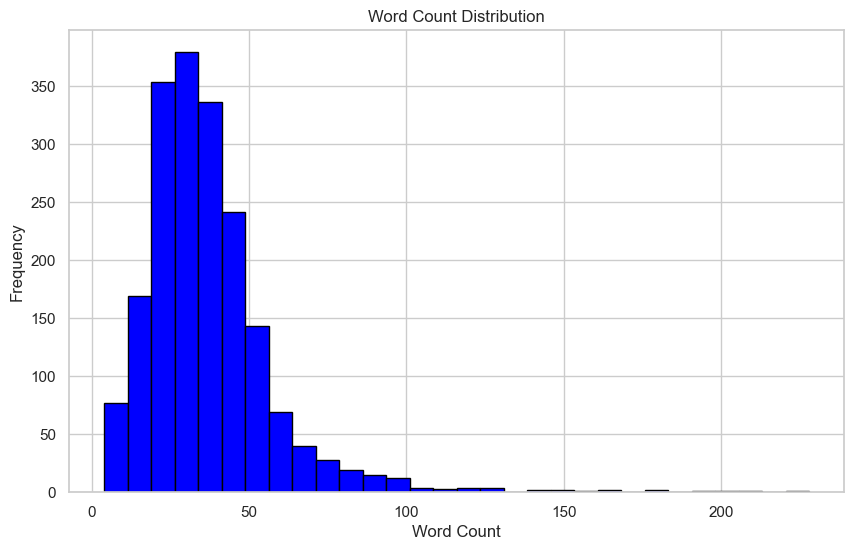

In [17]:
#Plot word count 
plt.figure(figsize=(10, 6))
plt.hist(data['word_count'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

#there seems to be a few extreme on 150+ words

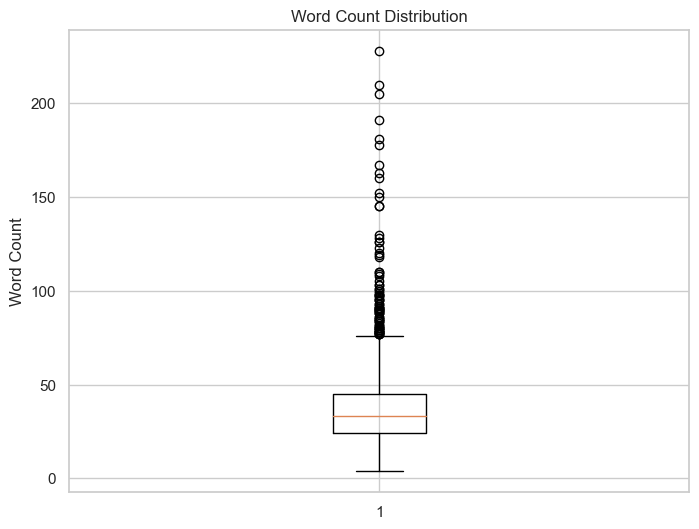

In [18]:

# A box plot of the word count distribution
plt.figure(figsize=(8, 6))
plt.boxplot(data['word_count'])
plt.ylabel('Word Count')
plt.title('Word Count Distribution')
plt.show()


#Not going to remove the outliers as the dataset is already small. Will note this as continue to use the dataset

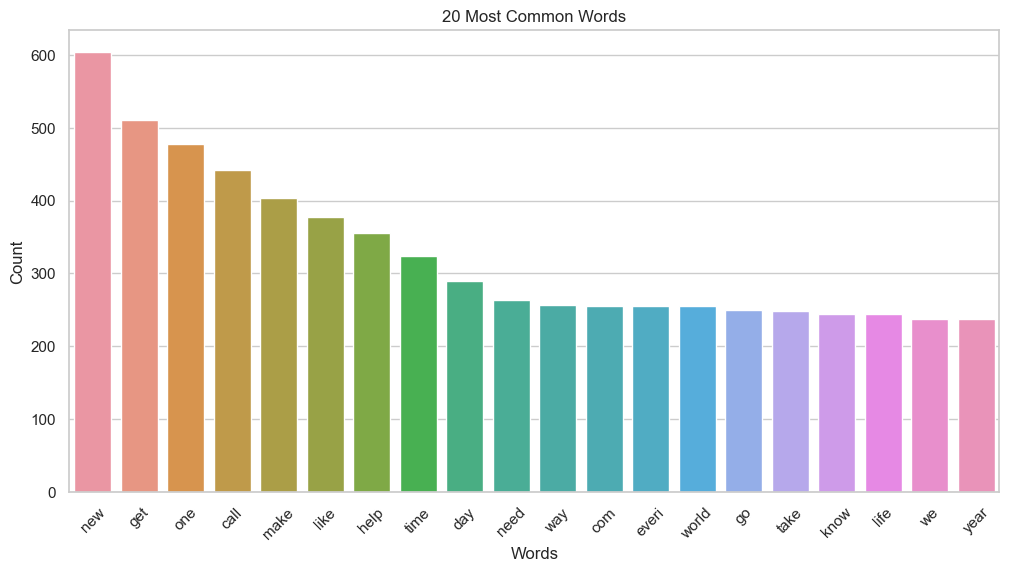

In [19]:
# Most common words 

# Flatten lists of words into a single list of words
all_words = [word for text in data['clean_copy'] for word in text]

# Create a Counter object to count the occurrences of each word
word_count = Counter(all_words)

# Find the 20 most common words
most_common_words = word_count.most_common(20)

# Bar plot
words, counts = zip(*most_common_words)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))

plt.title("20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



In [20]:

original_text = ' '.join(data['Ad_copy'])
original_words = original_text.split()
original_word_count = Counter(original_words)
most_common_original_words = original_word_count.most_common(20)

for word, count in most_common_original_words:
    print(f"{word}: {count}")


the: 4114
and: 2999
to: 2862
a: 2765
of: 2209
you: 1879
your: 1518
in: 1285
for: 1277
is: 1112
with: 965
that: 838
on: 684
The: 645
can: 633
it: 621
at: 582
or: 548
from: 518
are: 467


In [21]:
# Compare before and after 

word_comparison_df = pd.DataFrame({
    'Original_Word': [word for word, count in most_common_original_words],
    'Original_Count': [count for word, count in most_common_original_words],
    'Cleaned_Word': [word for word, count in most_common_words],
    'Cleaned_Count': [count for word, count in most_common_words]
})

print(word_comparison_df)

#The word 'com' might need to be remove as it maybe the end of website e.g. home.com > home com

   Original_Word  Original_Count Cleaned_Word  Cleaned_Count
0            the            4114          new            604
1            and            2999          get            511
2             to            2862          one            478
3              a            2765         call            442
4             of            2209         make            404
5            you            1879         like            377
6           your            1518         help            356
7             in            1285         time            324
8            for            1277          day            290
9             is            1112         need            264
10          with             965          way            257
11          that             838          com            256
12            on             684        everi            256
13           The             645        world            255
14           can             633           go            250
15            it        

In [22]:
random_sample = data.sample(n=5)

display(random_sample)

,Category,Ad_copy,clean_copy,word_count
1419,Media & Entertainment,There's a secret society where the night is et...,"[secret, societi, night, etern, music, essenti...",31
18,Advocacy,Passing gas around infants. Can be deadly. Pas...,"[pass, ga, around, infant, deadli, pass, ga, r...",35
1796,Travel,"Sandwiched between the North and Baltic Seas, ...","[sandwich, north, baltic, sea, denmark, jutlan...",28
1804,Travel,We live in a stressful world. Some estimates s...,"[live, stress, world, estim, say, doctor, visi...",38
745,Financial,MasterCard has something special in store for ...,"[mastercard, someth, special, store, holiday, ...",38


In [23]:
# Word list from literature and company research  

masculine_words = ['active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom', 'battle', 'boast', 'challeng', 'champion', 'compet', 'confident', 'courag', 'decid', 'decision', 'decisive', 'defend', 'determin', 'domina', 'dominant', 'driven', 'fearless', 'fight', 'force', 'greedy', 'head-strong', 'headstrong', 'hierarch', 'hostil', 'impulsive', 'independen', 'individual', 'intellect', 'lead', 'logic', 'objective', 'opinion', 'outspoken', 'persist', 'principle', 'reckless', 'self-confiden', 'self-relian', 'self-sufficien', 'selfconfiden', 'selfrelian', 'selfsufficien', 'stubborn', 'superior', 'unreasonab', 'Actor', 'Bogeyman', 'Boogeyman', 'Businessman', 'Businessmen', 'Chairman', 'Congressman', 'Fireman', 'Guys', 'Housekeeping', 'Mailman', 'Man hours', 'Man made', 'Man up', 'Mankind', 'Manpower', 'Mastered', 'Mastering', 'Old geezer', 'Policeman', 'Postman', 'Steward', 'The common man', 'gentlemen', 'male', 'man', 'master']

feminine_words = ['affectionate', 'agree', 'cheer', 'child', 'co-operat', 'collab', 'commit', 'communal', 'compassion', 'connect', 'considerate', 'cooperat', 'depend', 'emotiona', 'empath', 'enthusias', 'feel', 'flatterable', 'gentle', 'honest', 'inclusive', 'inter-dependen', 'inter-persona', 'inter-personal', 'interdependen', 'interpersona', 'interpersonal', 'kind', 'kinship', 'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet', 'respon', 'sensitiv', 'share', 'sharin', 'submissive', 'support', 'sympath', 'tender', 'together', 'trust', 'understand', 'warm', 'whin', 'yield', 'Actress', 'Crone', 'Female', 'Gals', 'Girl', 'Girls', 'Hag', 'Ladies', 'Ladies room', 'Lady', 'Lady time', 'Ladylike', 'Prostitute', 'Skank', 'Skanky', 'Slut', 'Stewardess', 'Stewardesses', 'Tramp', 'Whore', 'sirmadam']

# Common pronoun used text from spoken language 
masculine_pronouns = ['he', 'him', 'his', 'himself', 'man', 'men', 'male', 'father', 'brother', 'son', 'uncle', 'grandfather', 'nephew', 'husband', 'boyfriend', 'groom', 'king', 'prince', 'emperor', 'sir', 'lord']

feminine_pronouns = ['she', 'her', 'hers', 'herself', 'woman', 'women', 'female', 'mother', 'sister', 'daughter', 'aunt', 'grandmother', 'niece', 'wife', 'girlfriend', 'bride', 'queen', 'princess', 'empress', 'lady', 'madam']



In [24]:

# Checking text for word 

def find_gendered_words(tokens, word_list):
    return [word for word in word_list if word in tokens]


# Function to analyze and display gendered words information in the clean text

def analyze_gendered_words(clean_text, original_text):
    fem_words = find_gendered_words(clean_text, feminine_words)
    masc_words = find_gendered_words(clean_text, masculine_words)
    fempro_words = find_gendered_words(clean_text, feminine_pronouns)
    maspro_words = find_gendered_words(clean_text, masculine_pronouns)

    print('Feminine words in text:', len(fem_words))
    print('Masculine words in text:', len(masc_words))
    print('Pronouns words in text: fem', len(fempro_words), 'male', len(maspro_words))
    print('Pronouns words in text: fem', fempro_words, 'male', maspro_words)
    print('Feminine words found:', fem_words)
    print('Masculine words found:', masc_words)
    print('Original Ad_copy text:')
    print(original_text)

# Checking results 
sample_row = data.sample().iloc[0]
clean_text = sample_row['clean_copy']
original_text = sample_row['Ad_copy']
analyze_gendered_words(clean_text, original_text)




Feminine words in text: 0
Masculine words in text: 0
Pronouns words in text: fem 0 male 0
Pronouns words in text: fem [] male []
Feminine words found: []
Masculine words found: []
Original Ad_copy text:
"No matter how much you move around at night, there's a pad that can give you great protection. Introducing a new Always Overnight without wings. It's longer and wider to absorb what regular pads don't. Always Overnight now with or without wings."


In [25]:
total_fem_words = 0
total_masc_words = 0
total_fem_pronouns = 0
total_masc_pronouns = 0

for tokens in data['clean_copy']:
    fem_words = find_gendered_words(tokens, feminine_words)
    masc_words = find_gendered_words(tokens, masculine_words)
    total_fem_words += len(fem_words)
    total_masc_words += len(masc_words)

for tokens in data['clean_copy']:
    fem_pronouns = find_gendered_words(tokens, feminine_pronouns)
    masc_pronouns = find_gendered_words(tokens, masculine_pronouns)
    total_fem_pronouns += len(fem_pronouns)
    total_masc_pronouns += len(masc_pronouns)


print('Total feminine words in dataset:', total_fem_words)
print('Total masculine words in dataset:', total_masc_words)
print('Total feminine pronouns in dataset:', total_fem_pronouns)
print('Total masculine pronouns in dataset:', total_masc_pronouns)


# Interested to see the different stemming made in word counts, seem to increase all.
# Pre-stem fem words 416, mas 103, fem pronouns 230, mas pronouns 211

Total feminine words in dataset: 512
Total masculine words in dataset: 208
Total feminine pronouns in dataset: 228
Total masculine pronouns in dataset: 177


In [26]:
# Apply label 
# 0 = Neutral if total sum is equal to 0 or both fem and mas same count
# 1 = Fem pronoun count for 2 per noun and a fem words count 1 per word
# 2 = Mas pronoun count for 2 per noun and a mas words count 1 per word
# If mas total is high than fem total label masc OR
# If fem total is high than mas total label masc   

def label_gender(row):
    fem_words = find_gendered_words(row['clean_copy'], feminine_words)
    masc_words = find_gendered_words(row['clean_copy'], masculine_words)
    fem_pronouns = find_gendered_words(row['clean_copy'], feminine_pronouns)
    masc_pronouns = find_gendered_words(row['clean_copy'], masculine_pronouns)

    fem_total = len(fem_pronouns) * 2 + len(fem_words)
    masc_total = len(masc_pronouns) * 2 + len(masc_words)

    if fem_total == 0 and masc_total == 0:
        return 0
    elif fem_total > masc_total:
        return 1
    else:
        return 2

data['gender_label'] = data.apply(label_gender, axis=1)



In [27]:
#check labels 
random_sample = data.sample(n=5)

display(random_sample)

,Category,Ad_copy,clean_copy,word_count,gender_label
1898,Travel,"Timeless and full of life, the Hawaiian beache...","[timeless, full, life, hawaiian, beach, forev,...",33,2
1728,Telecommunications,Deploying IP Telephony can be a smart move. Go...,"[deploy, ip, telephoni, smart, move, gone, day...",29,0
688,Financial,Bank One's personal platinum. Choose your rate...,"[bank, one, person, platinum, choos, rate, rew...",21,0
122,Advocacy,You don't think much about it\nYou never dwell...,"[think, much, never, dwell, made, blanket, eve...",34,1
1828,Travel,"There's a place out there, it's different.\nA ...","[place, differ, place, peopl, understand, word...",36,1


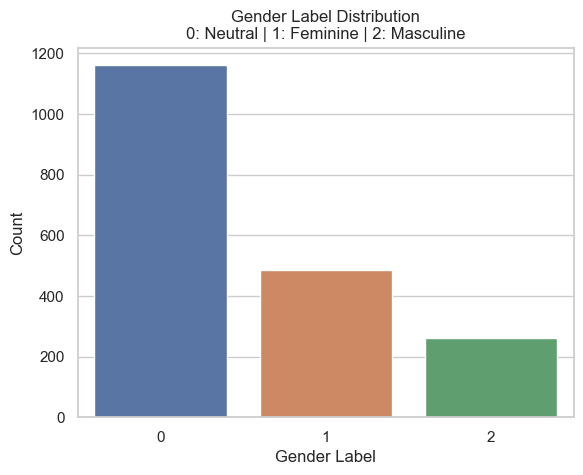

In [28]:
# Exploring label 

# Distribution of gender labels 
sns.countplot(x='gender_label', data=data)
plt.title("Gender Label Distribution\n0: Neutral | 1: Feminine | 2: Masculine")
plt.xlabel("Gender Label")
plt.ylabel("Count")
plt.show()



In [29]:
# Prepare the data for plotting
plot_data = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

# Create the stacked bar chart
ax = plot_data.plot(kind='barh', stacked=True, figsize=(10, 6))

# Set the axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Category')
ax.set_title('Gender Label Distribution by Category (Percentage)\n0: Neutral | 1: Feminine | 2: Masculine')

ax.legend(title='Gender Label', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


NameError: name 'plot_data' is not defined

In [ ]:
# Prepare the data for plotting
plot_data = data.groupby(['Category', 'gender_label']).size().unstack().fillna(0)

# Normalize the data (optional)
plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True, fmt='.2f', cmap='coolwarm')

# Set the axis labels and title
plt.xlabel('Gender Label')
plt.ylabel('Category')
plt.title('Gender Label Distribution by Category')

# Show the plot
plt.show()


Prep data for machine learning model 
- Drop unnecessary columns: Ad_copy, word_cont, Category
- Remove pronouns 
- Remove fem and mas words 
Note: Advised by Paul to remove the gendered word so the model does not replicate the manuel process created to label the data 

In [ ]:
# Prep data for claifaion model 

# Words to remove  

mas_words = ['active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert', 'athlet', 'autonom', 'battle', 'boast', 'challeng', 'champion', 'compet', 'confident', 'courag', 'decid', 'decision', 'decisive', 'defend', 'determin', 'domina', 'dominant', 'driven', 'fearless', 'fight', 'force', 'greedy', 'head-strong', 'headstrong', 'hierarch', 'hostil', 'impulsive', 'independen', 'individual', 'intellect', 'lead', 'logic', 'objective', 'opinion', 'outspoken', 'persist', 'principle', 'reckless', 'self-confiden', 'self-relian', 'self-sufficien', 'selfconfiden', 'selfrelian', 'selfsufficien', 'stubborn', 'superior', 'unreasonab', 'Actor', 'Bogeyman', 'Boogeyman', 'Businessman', 'Businessmen', 'Chairman', 'Congressman', 'Fireman', 'Guys', 'Housekeeping', 'Mailman', 'Man hours', 'Man made', 'Man up', 'Mankind', 'Manpower', 'Mastered', 'Mastering', 'Old geezer', 'Policeman', 'Postman', 'Steward', 'The common man', 'gentlemen', 'male', 'man', 'master']

fem_words = ['affectionate', 'agree', 'cheer', 'child', 'co-operat', 'collab', 'commit', 'communal', 'compassion', 'connect', 'considerate', 'cooperat', 'depend', 'emotiona', 'empath', 'enthusias', 'feel', 'flatterable', 'gentle', 'honest', 'inclusive', 'inter-dependen', 'inter-persona', 'inter-personal', 'interdependen', 'interpersona', 'interpersonal', 'kind', 'kinship', 'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet', 'respon', 'sensitiv', 'share', 'sharin', 'submissive', 'support', 'sympath', 'tender', 'together', 'trust', 'understand', 'warm', 'whin', 'yield', 'Actress', 'Crone', 'Female', 'Gals', 'Girl', 'Girls', 'Hag', 'Ladies', 'Ladies room', 'Lady', 'Lady time', 'Ladylike', 'Prostitute', 'Skank', 'Skanky', 'Slut', 'Stewardess', 'Stewardesses', 'Tramp', 'Whore', 'sirmadam']

mas_pro = ['he', 'him', 'his', 'himself', 'man', 'men', 'male', 'father', 'brother', 'son', 'uncle', 'grandfather', 'nephew', 'husband', 'boyfriend', 'groom', 'king', 'prince', 'emperor', 'sir', 'lord']

fem_pro = ['she', 'her', 'hers', 'herself', 'woman', 'women', 'female', 'mother', 'sister', 'daughter', 'aunt', 'grandmother', 'niece', 'wife', 'girlfriend', 'bride', 'queen', 'princess', 'empress', 'lady', 'madam']


# Combine into a single list
gendered_words = mas_words + feminine_words + mas_pro + fem_pro

# Function to remove gendered words from a list of words
def remove_gendered_words(word_list):
    return [word for word in word_list if word not in gendered_words]

# Remove gendered words from the 'clean_copy' column
data['clean_copy'] = data['clean_copy'].apply(remove_gendered_words)

# Show the modified DataFrame
print(data.head(2))


In [ ]:
# Drop unnecessary columns
columns_to_drop = ['Category', 'Ad_copy', 'word_count']

for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=column, inplace=True)


data.head(5)